<a href="https://colab.research.google.com/github/som-pat/Ryanair_NLP/blob/main/Ryanair_EDA_and_Comment_Analysis(Final).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'ryanair-reviews-ratings:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F4475073%2F7672164%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240526%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240526T060749Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D9001268745f9bd0e3ec673d7a8fcff4d42ed1066bae8f2155ece13e32ef4db8654a66cf30ca88dc7cdbdd2526b21674cf8848f987b76bc3b12594f3e4e7b7acdb4b89edb754c5b2b1605377074ed0fc250d75903088c772cce854bf9aa8a706e07f9fc5c3151b9a0d2cffa6420bee8924db3392ab9e5faf74506fc66031af9df9f42b9dd579c5dfb25935c2042be21828c5dcbfd078b44210b1a67a59d18ddc819f4814f9c47e5a95f7c56a2d030bb329a504c9c6598ddcdfa7534bd32b17f7c8db5b2594dbb43aa8a6535c3c98eb9d38f4c6e1d93b60b2e58415f40d757d67f90010d48ef3662ac3363228e5c2fd9a72566b29b8adf97617e90bb8cfc2912f4'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 644758 bytes downloaded
Downloaded and uncompressed: ryanair-reviews-ratings
Data source import complete.


 ## **Importing Libraries**

In [2]:
!pip install contractions --quiet
!pip install tensorflow keras --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.7/110.7 kB 13.7 MB/s eta 0:00:00


In [3]:
import nltk
import subprocess

try:
    nltk.data.find('wordnet.zip')
except:
    nltk.download('wordnet', download_dir='/kaggle/working/')
    command = "unzip /kaggle/working/corpora/wordnet.zip -d /kaggle/working/corpora"
    subprocess.run(command.split())
    nltk.data.path.append('/kaggle/working/')


from nltk.corpus import wordnet

[nltk_data] Downloading package wordnet to /kaggle/working/...


In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from wordcloud import WordCloud,STOPWORDS
from tqdm import tqdm


import contractions
import re
import string
import codecs


nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')
nltk.download('stopwords')

from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer,PorterStemmer

import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Input, Dropout, Flatten
from tensorflow.keras.models import load_model
from sklearn.model_selection import train_test_split

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


 ## **Data Loading and Overview**

In [5]:
ryanair = pd.read_csv('/kaggle/input/ryanair-reviews-ratings/ryanair_reviews.csv')

In [6]:
pd.set_option('display.max_columns', None)
ryanair.head()

,Unnamed: 0,Date Published,Overall Rating,Passenger Country,Trip_verified,Comment title,Comment,Aircraft,Type Of Traveller,Seat Type,Origin,Destination,Date Flown,Seat Comfort,Cabin Staff Service,Food & Beverages,Ground Service,Value For Money,Recommended,Inflight Entertainment,Wifi & Connectivity
0,0,2024-02-03,10.0,United Kingdom,Not Verified,"""bang on time and smooth flights""",Flew back from Faro to London Luton Friday 2nd...,Boeing 737 900,Family Leisure,Economy Class,Faro,Luton,February 2024,4.0,5.0,3.0,4.0,4.0,yes,NaN,NaN
1,1,2024-01-26,10.0,United Kingdom,Trip Verified,"""Another good affordable flight""",Another good affordable flight with Ryanair. O...,NaN,Couple Leisure,Economy Class,Belfast,Alicante,January 2024,3.0,5.0,3.0,5.0,5.0,yes,NaN,NaN
2,2,2024-01-20,10.0,United Kingdom,Trip Verified,“Really impressed!”,"Really impressed! You get what you pay for, th...",Boeing 737-800,Couple Leisure,Economy Class,Edinburgh,Paris Beauvais,October 2023,5.0,5.0,4.0,5.0,5.0,yes,NaN,NaN
3,3,2024-01-07,6.0,United Kingdom,Trip Verified,“a decent offering from Ryanair”,I should like to review my flight from Faro to...,Boeing 737,Solo Leisure,Economy Class,Faro,Liverpool,January 2024,3.0,2.0,1.0,3.0,3.0,yes,NaN,NaN
4,4,2024-01-06,10.0,Israel,Trip Verified,“cabin crew were welcoming and friendly”,"Flight left the gate ahead of schedule, fare w...",Boeing 737-800,Solo Leisure,Economy Class,Dublin,Manchester,January 2024,4.0,5.0,NaN,4.0,5.0,yes,NaN,NaN


In [7]:
ryanair.describe

<bound method NDFrame.describe of       Unnamed: 0 Date Published  Overall Rating Passenger Country  \
0              0     2024-02-03            10.0    United Kingdom   
1              1     2024-01-26            10.0    United Kingdom   
2              2     2024-01-20            10.0    United Kingdom   
3              3     2024-01-07             6.0    United Kingdom   
4              4     2024-01-06            10.0            Israel   
...          ...            ...             ...               ...   
2244        2244     2012-08-28             2.0    United Kingdom   
2245        2245     2012-08-28             1.0    United Kingdom   
2246        2246     2012-08-28             1.0    United Kingdom   
2247        2247     2012-08-28             1.0         Australia   
2248        2248     2012-08-23             2.0    United Kingdom   

      Trip_verified                             Comment title  \
0      Not Verified         "bang on time and smooth flights"   
1     Trip Verified          "Another good affordable flight"   
2     Trip Verified                       “Really impressed!”   
3     Trip Verified          “a decent offering from Ryanair”   
4     Trip Verified  “cabin crew were welcoming and friendly”   
...             ...                                       ...   
2244            NaN                   Ryanair customer review   
2245            NaN                   Ryanair customer review   
2246            NaN                   Ryanair customer review   
2247            NaN                   Ryanair customer review   
2248            NaN                   Ryanair customer review   

                                                Comment        Aircraft  \
0     Flew back from Faro to London Luton Friday 2nd...  Boeing 737 900   
1     Another good affordable flight with Ryanair. O...             NaN   
2     Really impressed! You get what you pay for, th...  Boeing 737-800   
3     I should like to review my flight from Faro to...      Boeing 737   
4     Flight left the gate ahead of schedule, fare w...  Boeing 737-800   
...                                                 ...             ...   
2244  Myself and my daughter took a holiday to Kos. ...             NaN   
2245  Stansted to Pula. Tried to adhere to all rules...             NaN   
2246  When printing the boarding tickets we got our ...             NaN   
2247  Budapest - Manchester and back again with a 5 ...             NaN   
2248  Stansted to Barcelona. Fine going there. Horre...             NaN   

     Type Of Traveller      Seat Type     Origin     Destination  \
0       Family Leisure  Economy Class       Faro           Luton   
1       Couple Leisure  Economy Class    Belfast        Alicante   
2       Couple Leisure  Economy Class  Edinburgh  Paris Beauvais   
3         Solo Leisure  Economy Class       Faro       Liverpool   
4         Solo Leisure  Economy Class     Dublin      Manchester   
...                ...            ...        ...             ...   
2244               NaN  Economy Class        NaN             NaN   
2245               NaN  Economy Class        NaN             NaN   
2246               NaN  Economy Class        NaN             NaN   
2247               NaN  Economy Class        NaN             NaN   
2248               NaN  Economy Class        NaN             NaN   

         Date Flown  Seat Comfort  Cabin Staff Service  Food & Beverages  \
0     February 2024           4.0                  5.0               3.0   
1      January 2024           3.0                  5.0               3.0   
2      October 2023           5.0                  5.0               4.0   
3      January 2024           3.0                  2.0               1.0   
4      January 2024           4.0                  5.0               NaN   
...             ...           ...                  ...               ...   
2244            NaN           1.0                  1.0               1.0   
2245            NaN           

In [8]:
print(ryanair.keys())
ryanair.info()

Index(['Unnamed: 0', 'Date Published', 'Overall Rating', 'Passenger Country',
       'Trip_verified', 'Comment title', 'Comment', 'Aircraft',
       'Type Of Traveller', 'Seat Type', 'Origin', 'Destination', 'Date Flown',
       'Seat Comfort', 'Cabin Staff Service', 'Food & Beverages',
       'Ground Service', 'Value For Money', 'Recommended',
       'Inflight Entertainment', 'Wifi & Connectivity'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2249 entries, 0 to 2248
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Unnamed: 0              2249 non-null   int64  
 1   Date Published          2249 non-null   object 
 2   Overall Rating          2119 non-null   float64
 3   Passenger Country       2249 non-null   object 
 4   Trip_verified           1305 non-null   object 
 5   Comment title           2249 non-null   object 
 6   Comment                 2249 non-null 

Given the number of missing datapoints in the column Inflight entertainment and Wifi & Connectivity their inclusion in the Overall Rating would not make much difference,hence they are to be dropped.

Food & Beverages is another column of concern since it also has a higher amount of missing data and it might affect the models evaluations.

The type of aircraft does not matter much because most of the time they are the same kind of aircrafts and the focus of the notebook is  not on analyzing the patterns and factors related to it.


 ## **Data Preprocessing**

In [9]:
print(ryanair.Recommended.unique())
print(ryanair.Trip_verified.unique())
print(set(ryanair['Type Of Traveller']))
print(set(ryanair['Seat Type']))

['yes' 'no']
['Not Verified' 'Trip Verified' nan 'NotVerified' 'Verified Review'
 'Unverified']
{'Couple Leisure', 'Family Leisure', 'Solo Leisure', nan, 'Business'}
{'First Class', 'Business Class', 'Premium Economy', 'Economy Class'}


In [10]:
ryanair.isnull().sum()

Unnamed: 0                   0
Date Published               0
Overall Rating             130
Passenger Country            0
Trip_verified              944
Comment title                0
Comment                      0
Aircraft                  1698
Type Of Traveller          614
Seat Type                    0
Origin                     615
Destination                615
Date Flown                 618
Seat Comfort               112
Cabin Staff Service        121
Food & Beverages           937
Ground Service             671
Value For Money              1
Recommended                  0
Inflight Entertainment    1918
Wifi & Connectivity       1981
dtype: int64

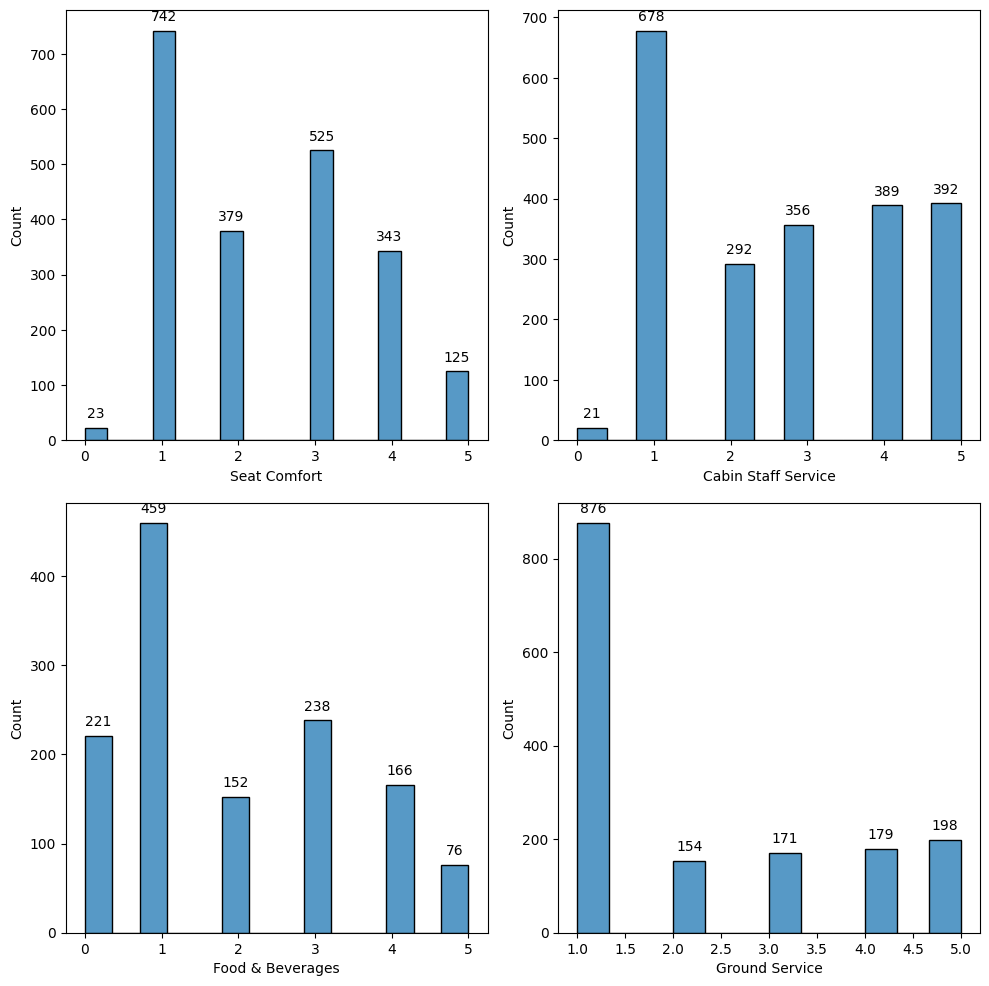

In [11]:
Ser_Col = ['Seat Comfort', 'Cabin Staff Service', 'Food & Beverages','Ground Service']
with pd.option_context('mode.use_inf_as_na', True):
    df2 = ryanair[Ser_Col].copy()


    fig, axes = plt.subplots(2, 2, figsize=(10, 10), dpi=100)
    #For easier  Iteration over subplots
    axes = axes.flatten()
    for i, column in enumerate(df2.columns):
        sns.histplot(df2[column], ax=axes[i])

        # Add count above each bar
        for patch in axes[i].patches:
            if patch.get_height()>0:
                axes[i].annotate(format(patch.get_height()),
                                    (patch.get_x() + patch.get_width() / 2., patch.get_height()),
                                    ha = 'center', va = 'center',
                                    xytext = (0, 10),
                                    textcoords = 'offset points')

    plt.tight_layout()
    plt.show()

The median as a measure of central tendency for this scenario is generally sound, especially if the data in the columns(ratings) are skewed or not normally distributed. Since ratings data are typically ordinal and may exhibit skewness towards certain values, the median offers a robust representation of the central tendency, preserving the order of values and minimizing the influence of outliers, thus providing a more accurate summary statistic for analysis.

In [12]:
ryanair[Ser_Col] = ryanair[Ser_Col].fillna(ryanair[Ser_Col].median())

In [13]:
#Manual check
se_co = ryanair['Seat Comfort'].value_counts().to_dict()

print(se_co)

{1.0: 742, 3.0: 525, 2.0: 491, 4.0: 343, 5.0: 125, 0.0: 23}


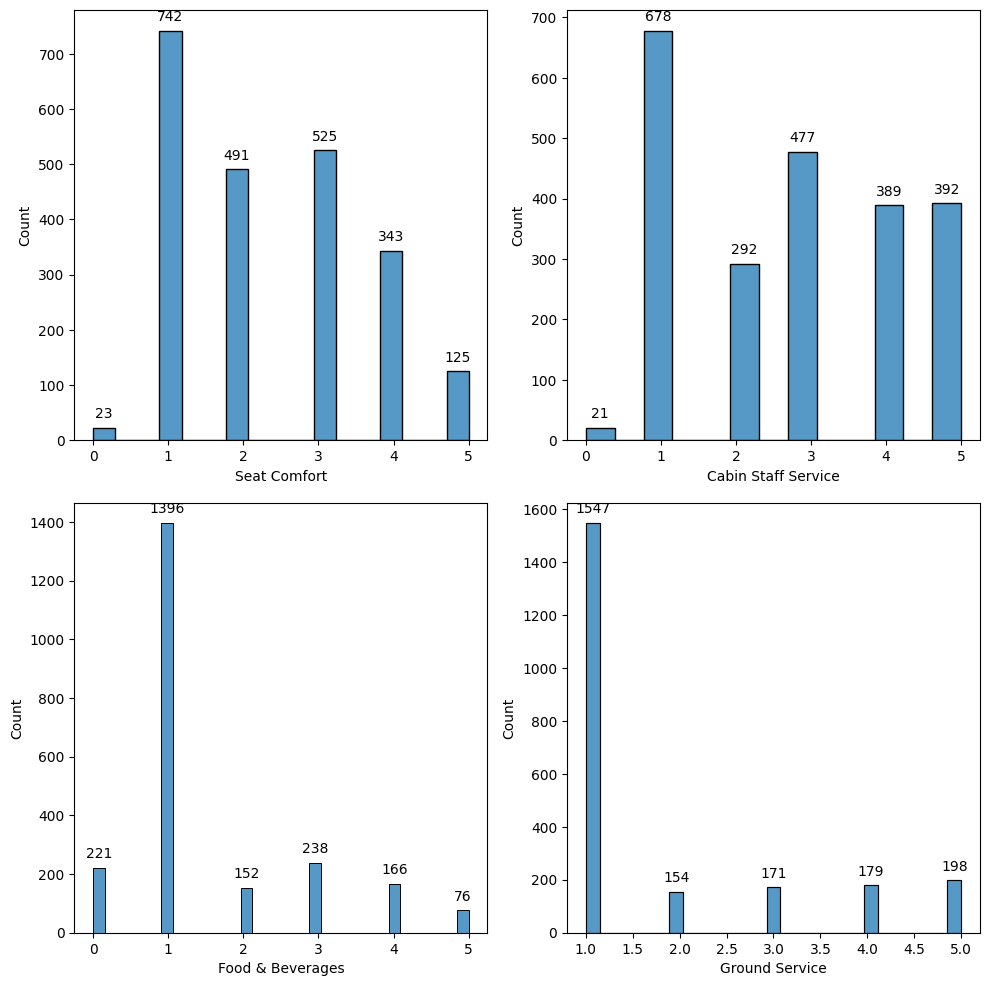

In [14]:

df2 = ryanair[Ser_Col].copy()
with pd.option_context('mode.use_inf_as_na', True):
    fig, axes = plt.subplots(2, 2, figsize=(10, 10), dpi=100)
    #For easier  Iteration over subplots
    axes = axes.flatten()
    for i, column in enumerate(df2.columns):
        sns.histplot(df2[column], ax=axes[i])

        # Add count above each bar
        for patch in axes[i].patches:
            if patch.get_height()>0:
                axes[i].annotate(format(patch.get_height()),
                                    (patch.get_x() + patch.get_width() / 2., patch.get_height()),
                                    ha = 'center', va = 'center',
                                    xytext = (0, 10),
                                    textcoords = 'offset points')

    plt.tight_layout()
    plt.show()

In [15]:
ryanair['Date Published'] = pd.to_datetime(ryanair['Date Published'])
ryanair['Trip_verified']=ryanair['Trip_verified'].astype(str)

In [16]:
# Replace values in 'Trip_verified' column using mapping dictionary
mapping = {
    np.nan: 'Unknown',
    'NotVerified': 'Not Verified',
    'Unverified': 'Not Verified',
    'Verified Review': 'Trip Verified'
}
ryanair['Trip_verified'] = ryanair['Trip_verified'].replace(mapping)

In [17]:
cat_col = ['Aircraft', 'Type Of Traveller', 'Origin', 'Destination']
ryanair[cat_col] = ryanair[cat_col].fillna('Unknown')

In [18]:
ryanair = ryanair.drop(columns='Unnamed: 0')

In [19]:
ryanair.isnull().sum()

Date Published               0
Overall Rating             130
Passenger Country            0
Trip_verified                0
Comment title                0
Comment                      0
Aircraft                     0
Type Of Traveller            0
Seat Type                    0
Origin                       0
Destination                  0
Date Flown                 618
Seat Comfort                 0
Cabin Staff Service          0
Food & Beverages             0
Ground Service               0
Value For Money              1
Recommended                  0
Inflight Entertainment    1918
Wifi & Connectivity       1981
dtype: int64

 ## **Exploratory Data Analysis(EDA)**

Recommended      no  yes
Overall Rating          
1.0             852    6
2.0             177    7
3.0              95    7
4.0              49    8
5.0              45   38
6.0              17   59
7.0               4  118
8.0               2  196
9.0               4  173
10.0              2  260


<Figure size 1200x600 with 0 Axes>

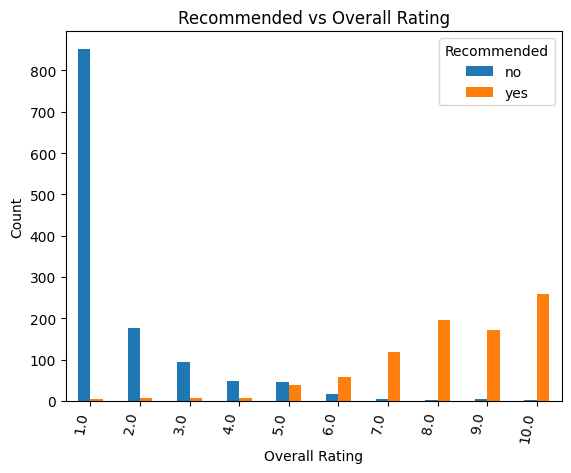

In [20]:
#@title Overall Rating vs Recommendation
fig = plt.figure(dpi=100, figsize=(12, 6))
count_rec_rate = ryanair.groupby(['Overall Rating','Recommended']).size().unstack(fill_value=0)
print(count_rec_rate)
count_rec_rate.plot(kind='bar',stacked=False)
plt.xlabel('Overall Rating')
plt.xticks(rotation=80, ha='right')
plt.ylabel('Count')
plt.title('Recommended vs Overall Rating')

# Show the plot
plt.show()

In [21]:
# Recommendation and Rating on the basis of Seat type, Comfort and Group or Solo Travellers
SeaGrou = ['Overall Rating','Seat Type','Seat Comfort','Type Of Traveller','Recommended']
df3 = ryanair[SeaGrou].copy()



<Axes: xlabel='Seat Type', ylabel='Seat Comfort'>

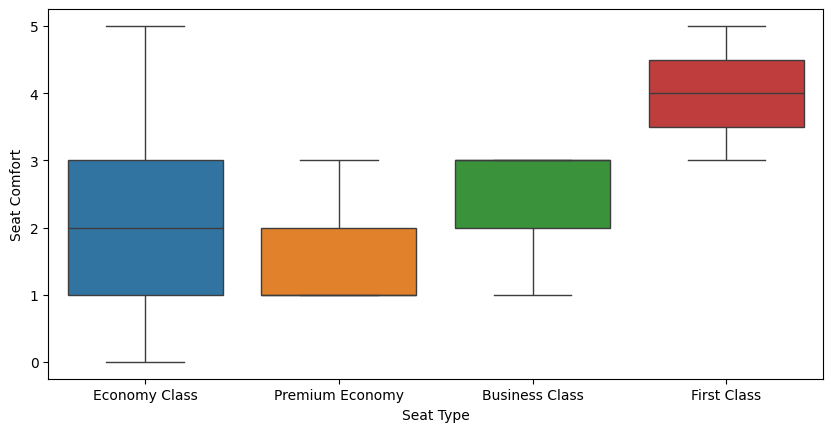

In [22]:
#@title 'Seat Type' vs 'Seat Comfort'
figsize = (10, 1.2 * len(df3['Seat Type'].unique()))
plt.figure(figsize=figsize)
sns.boxplot(df3,x='Seat Type',y='Seat Comfort',hue='Seat Type')

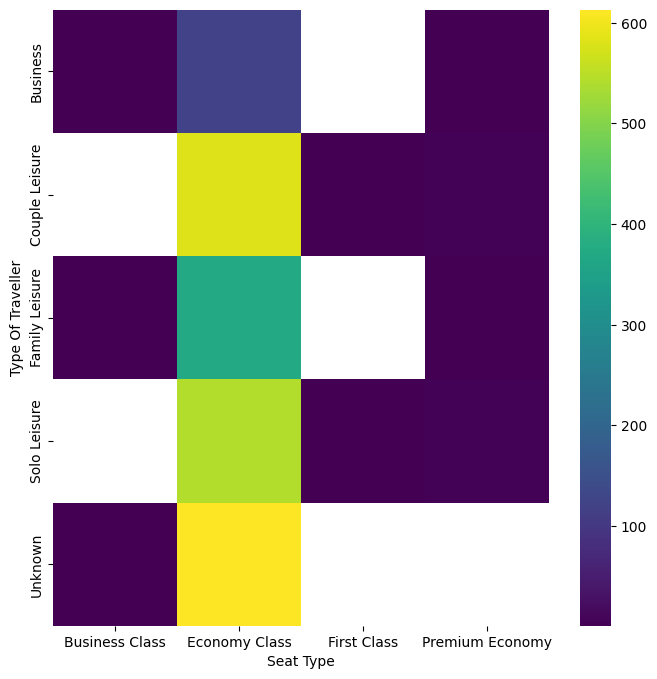

In [23]:
# @title Seat Type vs Type Of Traveller

plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['Type Of Traveller'].value_counts()
    for x_label, grp in df3.groupby('Seat Type')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('Seat Type')
_ = plt.ylabel('Type Of Traveller')

Recommended         no  yes
Type Of Traveller          
Business            78   48
Couple Leisure     427  160
Family Leisure     257  117
Solo Leisure       329  219
Unknown            286  328


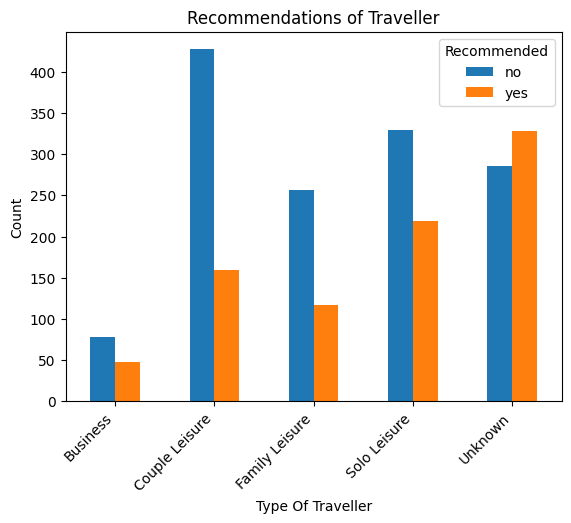

In [24]:
# @title Type of Traveller vs Overall Recommendations
count_traveller_type = ryanair.groupby(['Type Of Traveller','Recommended']).size().unstack(fill_value=0)
print(count_traveller_type)
count_traveller_type.plot(kind='bar',stacked=False)
plt.xlabel('Type Of Traveller')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.title('Recommendations of Traveller')

# Show the plot
plt.show()


 ## **Sentiment Analysis of Reviews**

In [25]:
# @title Comment NLP
com_df = ['Comment title', 'Comment','Recommended']
comm_df = ryanair[com_df].copy()

comm_df.head(5)

,Comment title,Comment,Recommended
0,"""bang on time and smooth flights""",Flew back from Faro to London Luton Friday 2nd...,yes
1,"""Another good affordable flight""",Another good affordable flight with Ryanair. O...,yes
2,“Really impressed!”,"Really impressed! You get what you pay for, th...",yes
3,“a decent offering from Ryanair”,I should like to review my flight from Faro to...,yes
4,“cabin crew were welcoming and friendly”,"Flight left the gate ahead of schedule, fare w...",yes


In [26]:
def expand_contractions(comment):
    # Expand shortened version of phrases or words
    comment = contractions.fix(comment)

    return comment

In [27]:
def replace_numbers(comment):
    # Removal of numbers from tweet
    return re.sub('[0-9]+', '', comment)

In [28]:
def remove_ordinals(comment):
    # Define a regular expression pattern to match ordinal numbers
    ordinal_pattern = r'\b\d+(st|nd|rd|th)\b'
    # Replace ordinal numbers with an empty string
    cleaned_text = re.sub(ordinal_pattern, '', comment)
    return cleaned_text

In [29]:
nonstandard_dict = {
    'aint': 'am not',
    'gonna': 'going to',
    'gotta': 'got to',
    'hafta': 'have to',
    'wanna': 'want to',
    'coulda': 'could have',
    'woulda': 'would have',
    'shoulda': 'should have',
    'mighta': 'might have',
    'musta': 'must have',
    'ain\'t': 'am not',
    'kinda': 'kind of',
    'sorta': 'sort of'
}

def replace_nonstandard(comment, nonstandard_dict):
    # To replace slag words which are non-english words to their corresponding english words
    nonstd_comment = []
    for word in comment.split():
        if word in nonstandard_dict:
            nonstd_comment.append(nonstandard_dict[word])
        else:
            nonstd_comment.append(word)

    return ' '.join(nonstd_comment)


In [30]:

# Remove punctuations
punctuations = string.punctuation
def remove_punctuations(comment):
    # Removal of punctuations from tweets
    return comment.translate(str.maketrans('', '', punctuations))

In [31]:
StopWords_list = stopwords.words('english')
print(StopWords_list)
def remove_stopwords(comment):
    # Removal of stopwords from tweets which have no or less meaning to reduce noise
    return " ".join([word for word in str(comment).split() if word not in StopWords_list])

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [32]:
def tokenizer(comment):
    tokenizer = RegexpTokenizer(r'\w+|[^\w\s]')
    return tokenizer.tokenize(comment)

In [33]:
lemmatizer = WordNetLemmatizer()
wordnet_map = {"N":wordnet.NOUN, "V":wordnet.VERB, "J":wordnet.ADJ, "R":wordnet.ADV}
def lemmatize_words(comment):
  # Tag each word in the tweet with its corresponding part-of-speech.
  pos_tagged_comment = nltk.pos_tag(comment.split())
  # lemmatizer is applied to each word in the tweet using the WordNet POS tag. If the POS is not found in the wordnet dict, the default tag used is NOUN.
  return " ".join([lemmatizer.lemmatize(word, wordnet_map.get(pos[0], wordnet.NOUN)) for word, pos in pos_tagged_comment])


In [34]:
def preprocessing_comments(comment):
    comment = expand_contractions(comment)
    comment = remove_ordinals(comment)
    comment = replace_numbers(comment)
    comment = replace_nonstandard(comment, nonstandard_dict)
    comment = remove_punctuations(comment)
    comment = comment.lower()
    comment = remove_stopwords(comment)
    # comment = stemmer(comment)
    comment = str(lemmatize_words(comment))

    return comment

In [35]:
comm_df['Comment title'] = comm_df['Comment title'].apply(lambda x: preprocessing_comments(x))
comm_df['Comment'] = comm_df['Comment'].apply(lambda x: preprocessing_comments(x))

In [36]:
comm_df.head(10)

,Comment title,Comment,Recommended
0,bang time smooth flight,flew back faro london luton friday february ry...,yes
1,another good affordable flight,another good affordable flight ryanair time pl...,yes
2,“really impressed”,really impressed get pay flight cost £ seat so...,yes
3,“a decent offering ryanair”,like review flight faro liverpool ryanair book...,yes
4,“cabin crew welcome friendly”,flight leave gate ahead schedule fare really c...,yes
5,close online checkin hour,book fight copenhagen poland though bookingcom...,no
6,really good value,flight operate malta air always find cabin cre...,yes
7,ask pay backpack,staff rude manner let alone professional backp...,no
8,ground service staff really bad,ryanair ground service staff really bad proble...,no
9,make u pay show fee,want check online night flight nationality lis...,no


In [37]:
print(len(comm_df['Comment'][92]))

213


In [38]:
# Recommendation Label Encoding yes/no to 1/0
comm_df['Recommended'] = comm_df['Recommended'].astype('category')
comm_df['Suggest'] = comm_df['Recommended'].cat.codes
comm_df.head(10)

,Comment title,Comment,Recommended,Suggest
0,bang time smooth flight,flew back faro london luton friday february ry...,yes,1
1,another good affordable flight,another good affordable flight ryanair time pl...,yes,1
2,“really impressed”,really impressed get pay flight cost £ seat so...,yes,1
3,“a decent offering ryanair”,like review flight faro liverpool ryanair book...,yes,1
4,“cabin crew welcome friendly”,flight leave gate ahead schedule fare really c...,yes,1
5,close online checkin hour,book fight copenhagen poland though bookingcom...,no,0
6,really good value,flight operate malta air always find cabin cre...,yes,1
7,ask pay backpack,staff rude manner let alone professional backp...,no,0
8,ground service staff really bad,ryanair ground service staff really bad proble...,no,0
9,make u pay show fee,want check online night flight nationality lis...,no,0


In [39]:
comm_df['Comment']=comm_df['Comment'].astype(str)
comm_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2249 entries, 0 to 2248
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Comment title  2249 non-null   object  
 1   Comment        2249 non-null   object  
 2   Recommended    2249 non-null   category
 3   Suggest        2249 non-null   int8    
dtypes: category(1), int8(1), object(2)
memory usage: 39.8+ KB


In [40]:
comm_df.loc[comm_df['Suggest'] == 1, 'Comment']

0       flew back faro london luton friday february ry...
1       another good affordable flight ryanair time pl...
2       really impressed get pay flight cost £ seat so...
3       like review flight faro liverpool ryanair book...
4       flight leave gate ahead schedule fare really c...
                              ...                        
2232    flew first time ryanair son wed poland crucial...
2234    july bristol tenerife family adult child know ...
2235    ryanair good destination small airport closer ...
2237    flown ryanair many time return lanzarote fly e...
2241    flew recently manchester bremen germany alread...
Name: Comment, Length: 872, dtype: object

In [41]:
comm_df.loc[comm_df['Suggest'] == 0, 'Comment']

5       book fight copenhagen poland though bookingcom...
7       staff rude manner let alone professional backp...
8       ryanair ground service staff really bad proble...
9       want check online night flight nationality lis...
11      airline charge almost every thing every child ...
                              ...                        
2244    daughter take holiday ko never see shamble lif...
2245    stansted pula try adhere rule regulation fail ...
2246    print board ticket get outboard flight problem...
2247    budapest manchester back month old year old bu...
2248    stansted barcelona fine go horrendous treatmen...
Name: Comment, Length: 1377, dtype: object

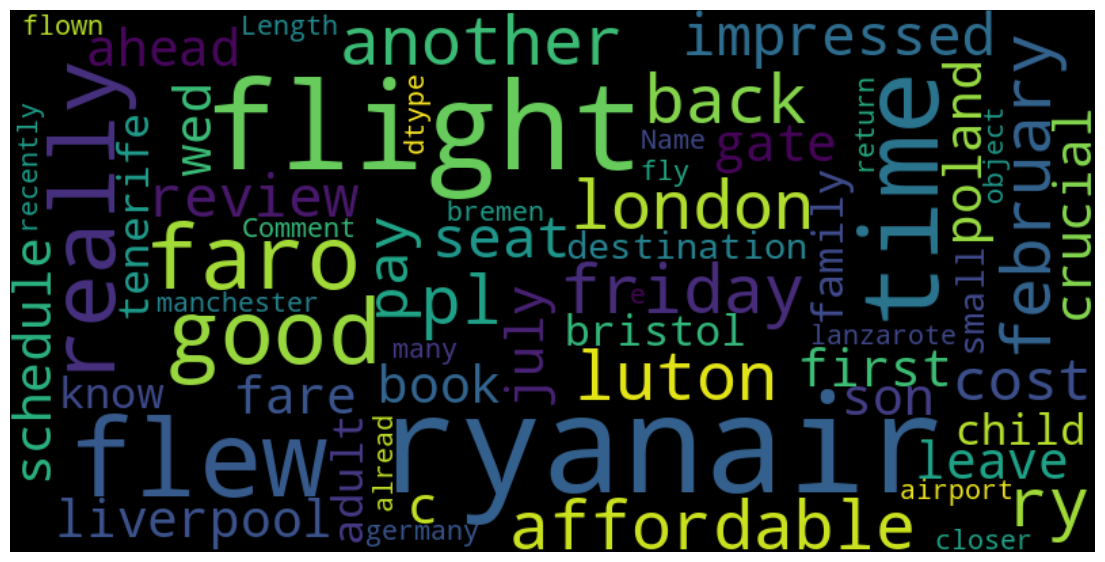

In [42]:
s_word = set(STOPWORDS)
wordcloud1 = WordCloud(background_color='black', stopwords =s_word ,
                max_words = 400, max_font_size = 100,
                random_state = 17, width=800, height=400)

plt.figure(figsize=(14, 14))
wordcloud1.generate(str(comm_df.loc[comm_df['Suggest'] == 1, 'Comment']))

plt.imshow(wordcloud1, interpolation='bilinear')
plt.axis('off')
plt.show()


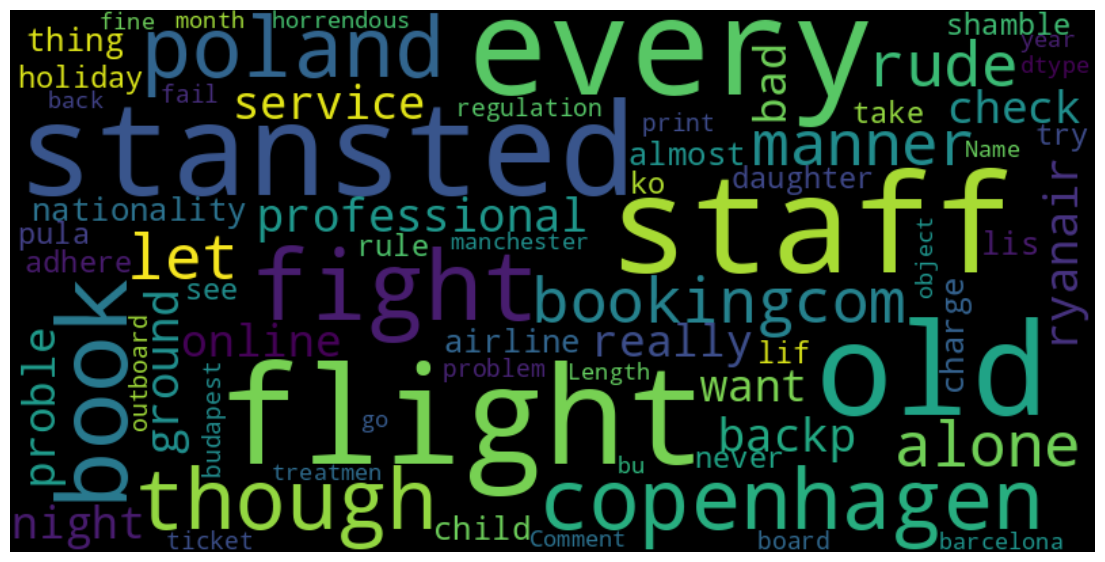

In [43]:
wordcloud2 = WordCloud(background_color='black', stopwords =s_word ,
                max_words = 400, max_font_size = 100,
                random_state = 17, width=800, height=400)

plt.figure(figsize=(14, 14))
wordcloud1.generate(str(comm_df.loc[comm_df['Suggest'] == 0, 'Comment']))

plt.imshow(wordcloud1, interpolation='bilinear')
plt.axis('off')
plt.show()

In [44]:

# @title variation of comment length

comm_df['Com_len'] = comm_df['Comment'].apply(lambda x: len(x))
comm_df.head(10)

,Comment title,Comment,Recommended,Suggest,Com_len
0,bang time smooth flight,flew back faro london luton friday february ry...,yes,1,319
1,another good affordable flight,another good affordable flight ryanair time pl...,yes,1,115
2,“really impressed”,really impressed get pay flight cost £ seat so...,yes,1,167
3,“a decent offering ryanair”,like review flight faro liverpool ryanair book...,yes,1,692
4,“cabin crew welcome friendly”,flight leave gate ahead schedule fare really c...,yes,1,140
5,close online checkin hour,book fight copenhagen poland though bookingcom...,no,0,611
6,really good value,flight operate malta air always find cabin cre...,yes,1,650
7,ask pay backpack,staff rude manner let alone professional backp...,no,0,326
8,ground service staff really bad,ryanair ground service staff really bad proble...,no,0,204
9,make u pay show fee,want check online night flight nationality lis...,no,0,422


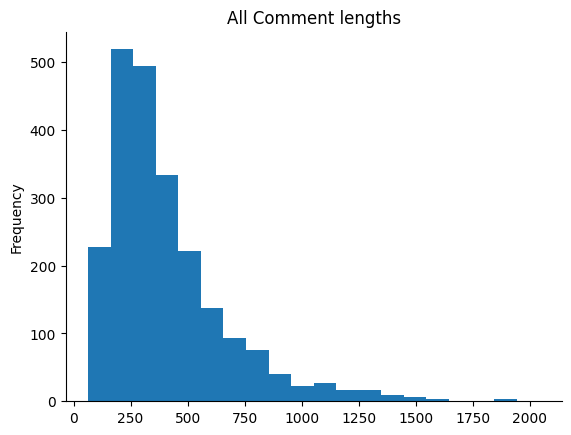

In [45]:
# @title Com_len

comm_df['Com_len'].plot(kind='hist', bins=20, title='All Comment lengths')
plt.gca().spines[['top', 'right',]].set_visible(False)

Text(0.5, 0, 'Comment Length')

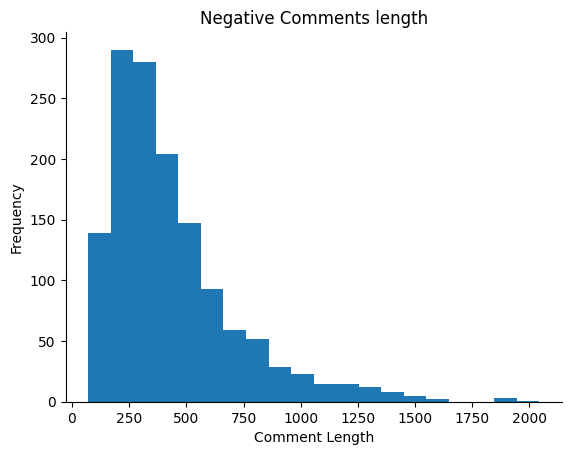

In [46]:

# @title Negative vs Positive comemnt Length
Negative = comm_df.loc[comm_df['Suggest'] == 0, 'Com_len']
Positive = comm_df.loc[comm_df['Suggest'] == 1, 'Com_len']

Negative.plot(kind='hist', bins=20, title='Negative Comments length')
plt.gca().spines[['top', 'right',]].set_visible(False)
plt.xlabel('Comment Length')


Text(0.5, 0, 'Comment Length')

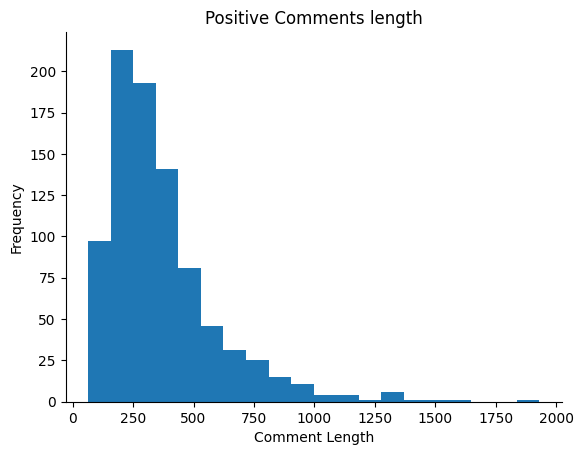

In [47]:
Positive.plot(kind='hist', bins=20, title='Positive Comments length')
plt.gca().spines[['top', 'right',]].set_visible(False)
plt.xlabel('Comment Length')

In [48]:
comm_df['Com_len'].describe()

count    2249.000000
mean      409.010671
std       264.980335
min        64.000000
25%       226.000000
50%       338.000000
75%       508.000000
max      2042.000000
Name: Com_len, dtype: float64

In [49]:

# @title Removing outliers in Comments len > 1200


df_1200_sug = comm_df[comm_df['Com_len'] > 1200].groupby('Suggest').size()
df_900_sug = comm_df[(comm_df['Com_len'] > 900) & (comm_df['Com_len'] < 1200)].groupby('Suggest').size()

print(df_1200_sug)
print(df_900_sug)

df_1200 = comm_df[comm_df['Com_len']>1200]
comm_df = comm_df.drop(df_1200.index,axis = 0)
comm_df.reset_index(drop = True, inplace = True)


Suggest
0    33
1    11
dtype: int64
Suggest
0    68
1    19
dtype: int64


In [50]:
comm_df[40:50]

,Comment title,Comment,Recommended,Suggest,Com_len
40,charge one u € checkin,group travel across europe go ryanair one flig...,no,0,402
41,charge extra small bag,first ticket low cost flight athens vilnius ba...,no,0,171
42,good value money,pleasant experience flight little delayed staf...,yes,1,125
43,sell seat pay,check back app flight home go ryanair remove f...,no,0,189
44,pay extra bag fee,horrible airline never fly choice fly “dollars...,no,0,206
45,never use,six u adult kid bad experience stansted airpor...,no,0,457
46,pay money back cancel flight,bad airline ever flight marrakech back berlin ...,no,0,310
47,pay another euro check,bad airline ever deal super incompetent unfrie...,no,0,590
48,leg room great,flight delay minute one crew member quite rude...,yes,1,136
49,staff gate refuse boarding,recently miss flight france staff member gate ...,no,0,425


In [51]:
# Embedding Layer Configuration for BiLSTM Model
# ---------------------------------------------

# `vocab_size`:
#   - This is the total number of unique words (or tokens) in your vocabulary.
#   - Includes special tokens like padding token (<PAD>), unknown token (<UNK>),
#     start-of-sequence token (<SOS>), and end-of-sequence token (<EOS>) if used.

# `embedding_dim`:
#   - This determines the dimensionality of the dense vector that will represent each word.
#   - Common choices are 50, 100, 200, or 300 dimensions.
#   - Higher dimensions can capture more nuanced relationships,
#     but may increase computational complexity.

# `max_length`:
#   - This is the maximum length (number of words) allowed in your input sequences.
#   - Sequences shorter than this will be padded, and longer sequences will be truncated.

# Create the Embedding Layer in Keras/TensorFlow


In [52]:
# Build word corpus
corpus = [comm_df['Comment'][i] for i in range(len(comm_df))]
embedding_vector_features= 60
# Build word tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(comm_df.Comment)
vocab_size = len(tokenizer.word_index) + 1
# Onehot embedding of the corpus using the tokenized words
onehot_tag=[one_hot(words,vocab_size)for words in corpus]
# Maximum sentence length for padding
max_comm_length = max(len(seq) for seq in comm_df.Comment)
# Padding of the sentences
padded_comments = pad_sequences(onehot_tag,maxlen=max_comm_length,padding='post', truncating='post', value=0)

In [53]:
# padded_comments = pad_sequences(onehot_tag,maxlen=max_comm_length,padding='post', truncating='post', value=0)

In [54]:
padded_comments

array([[5677, 6031,  909, ...,    0,    0,    0],
       [2946, 4308, 4756, ...,    0,    0,    0],
       [ 897,  637, 3918, ...,    0,    0,    0],
       ...,
       [5762, 5642, 4923, ...,    0,    0,    0],
       [1862, 3499, 6031, ...,    0,    0,    0],
       [5518, 5178,   17, ...,    0,    0,    0]], dtype=int32)

In [55]:
Y = comm_df['Suggest']
X = padded_comments
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=42, test_size=0.20,shuffle=True)

In [56]:
# @title Bilstm model
# Hyperparameters
BiLstm_model = Sequential()
BiLstm_model.add(Embedding(input_dim =vocab_size,output_dim=embedding_vector_features ,
                           input_length=max_comm_length))

BiLstm_model.add(Bidirectional(LSTM(64, return_sequences = True)))
BiLstm_model.add(Bidirectional(LSTM(units=64, dropout=0.3, recurrent_dropout=0.3)))
BiLstm_model.add(Dense(units=1, activation="sigmoid"))
BiLstm_model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
print(BiLstm_model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1192, 60)          451800    
                                                                 
 bidirectional (Bidirection  (None, 1192, 128)         64000     
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 128)               98816     
 onal)                                                           
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 614745 (2.35 MB)
Trainable params: 614745 (2.35 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [57]:
history = BiLstm_model.fit(x_train, y_train, batch_size=64, epochs=6)

Epoch 1/6
28/28 [==============================] - 228s 8s/step - loss: 0.6240 - accuracy: 0.6463
Epoch 2/6
28/28 [==============================] - 213s 8s/step - loss: 0.3098 - accuracy: 0.8912
Epoch 3/6
28/28 [==============================] - 212s 8s/step - loss: 0.1525 - accuracy: 0.9535
Epoch 4/6
28/28 [==============================] - 212s 8s/step - loss: 0.0831 - accuracy: 0.9768
Epoch 5/6
28/28 [==============================] - 210s 7s/step - loss: 0.0533 - accuracy: 0.9847
Epoch 6/6
28/28 [==============================] - 211s 8s/step - loss: 0.0358 - accuracy: 0.9921


In [58]:
# Testing the model after training
test_results = BiLstm_model.evaluate(x_test, y_test, verbose=1)

14/14 [==============================] - 11s 707ms/step - loss: 0.4460 - accuracy: 0.8889


In [59]:
print(f'Test results - Loss: {test_results[0]} - Accuracy: {100*test_results[1]}%')

Test results - Loss: 0.44599565863609314 - Accuracy: 88.88888955116272%


Text(0, 0.5, 'Accuarcy Value(%)')

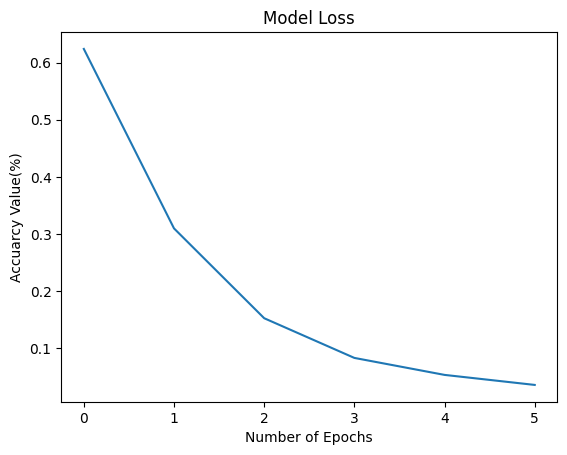

In [60]:
# Model Training Loss
plt.plot(history.history['loss'])
plt.title("Model Loss")
plt.xlabel("Number of Epochs")
plt.ylabel("Accuarcy Value(%)")

Text(0, 0.5, 'Accuarcy Value(%)')

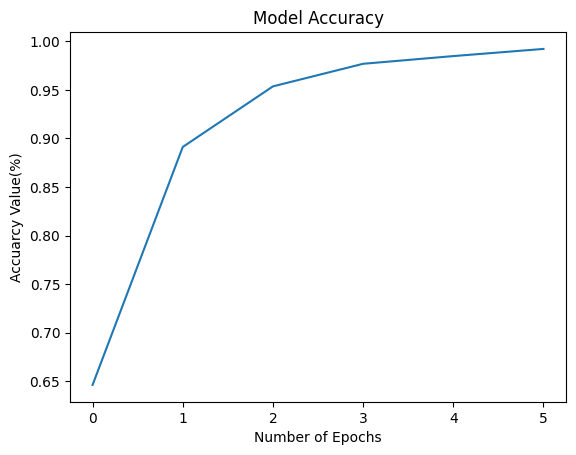

In [61]:
# Model Accuracy
plt.plot(history.history['accuracy'])
plt.title("Model Accuracy")
plt.xlabel("Number of Epochs")
plt.ylabel("Accuarcy Value(%)")